# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.load_example_raw('Dy164')
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut(axis='Ex', limits=[0, 8400])
raw.plot()

<IPython.core.display.Javascript object>

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

fname_resp_mat = "../data/Dy164_response_matrix.m"
fname_resp_dat = "../data/Dy164_response_parameters.dat"

unfolder = om.Unfolder()
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)
unfolded.plot()

<IPython.core.display.Javascript object>

In [4]:
firstgen = om.first_generation_method(unfolded, Ex_max=8500, dE_gamma=500)
firstgen.plot(zmin=1e-3)

  warnings.warn("Hello from the fill_negative() function. Please debug me.")



<IPython.core.display.Javascript object>

In [5]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

unfolder = om.Unfolder()
unfolder.cut_diagonal((800, 0), (7500, 7300))
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)

def firstmethod(U):
    return om.first_generation_method(matrix_in=U, Ex_max=8500,
                                     dE_gamma=800,multiplicity_estimation="statistical")

ensemble = om.Ensemble(raw=raw)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstmethod
ensemble.generate(number=10, regenerate=True)


INFO:ompy.ensemble:Generating 0
  fluctuations /= self.fluctuations(self.r)

INFO:ompy.ensemble:Generating 1
INFO:ompy.ensemble:Generating 2
INFO:ompy.ensemble:Generating 3
INFO:ompy.ensemble:Generating 4
INFO:ompy.ensemble:Generating 5
INFO:ompy.ensemble:Generating 6
INFO:ompy.ensemble:Generating 7
INFO:ompy.ensemble:Generating 8
INFO:ompy.ensemble:Generating 9


In [6]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ensemble.std_raw.plot(ax=ax[0])
ensemble.std_unfolded.plot(ax=ax[1])
ensemble.std_firstgen.plot(ax=ax[2])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [7]:
bin_width_out = 150
Ex_min = 4000
Ex_max = 8000
Eg_min = 1000

ftol = 1e-4 # Fitting tolerance (in some unknown, relative units)
maxfev = 9000 # maximum number of function evaluations

N_fits = 10

In [8]:
# Decomposition with the new 1Gen matrixes -- if saved, just load them again

rho_ens = []
gsf_ens = []
try:
    nld_Earray = np.loadtxt("error_propagation_ensemble/rho_E_array.txt")
    gsf_Earray = np.loadtxt("error_propagation_ensemble/gsf_E_array.txt")
    for i in range(N_fits):
        rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i))
        gsf_val = np.loadtxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i))
        rho = om.Vector(rho_val, nld_Earray)
        rho_ens.append(rho)
        gsf = om.Vector(gsf_val, gsf_Earray)
        gsf_ens.append(gsf)
except:
    std = ensemble.std_firstgen
    for i in range(N_fits):
        print("Start of iteration {}".format(i))
        mat = om.Matrix(ensemble.firstgen_ensemble[i],
                     Ex=std.Ex,
                     Eg=std.Eg)
        fits = om.FitRhoT(mat, std, bin_width_out,
                              Ex_min, Ex_max, Eg_min,
                              method="Powell",
                              options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                              #error_normalization="approximate"
                             )
        rho_ens.append(fits.rho)
        T = fits.T
        gsf = T.values / (2 * np.pi * (T.E_array)**3)
        gsf_ens.append(om.Vector(gsf,T.E_array))

        np.savetxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i), rho_ens[i].values)
        np.savetxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i), gsf_ens[i].values)

    np.savetxt("error_propagation_ensemble/rho_E_array.txt", rho_ens[0].E_array)
    np.savetxt("error_propagation_ensemble/gsf_E_array.txt", gsf_ens[0].E_array)

rho_ens_initial = rho_ens
gsf_ens_initial = gsf_ens

In [9]:
# Do the fits look the same (using the previously estimated 1Gen matrix and the updated version)?
def plot_nld_gsf(rho_ens, gsf_ens):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    for i in range(10):
        ax1.plot(rho_ens[i].E_array, rho_ens[i].values, "-", label=str(i))
        ax2.plot(gsf_ens[i].E_array, gsf_ens[i].values, "-")
    ax1.set_yscale("log")
    ax1.legend()
    ax2.set_yscale("log")
    plt.plot()

plot_nld_gsf(rho_ens_initial, gsf_ens_initial)

<IPython.core.display.Javascript object>

In [10]:
# plot initial rho and gsf
rho_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initial], axis=0)

rho_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initial], axis=0)

std_rel_nld = {}
std_rel_nld["fit"] = rho_std/rho_mean

std_rel_gsf = {}
std_rel_gsf["fit"] = gsf_std/gsf_mean


fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_ens[0].E_array, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E_array, gsf_mean, yerr=gsf_std, fmt="o")

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

In [11]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style

In [12]:
import copy
# just giving it a try
alpha = 2
A = 1
B = 10

rho_ens_initialMeV = copy.deepcopy(rho_ens_initial)
gsf_ens_initialMeV = copy.deepcopy(gsf_ens_initial)

E_array = rho_ens_initial[0].E_array/1e3
for i in range(len(rho_ens_initialMeV)):
    rho_ens_initialMeV[i].E_array = E_array
    
E_array = gsf_ens_initial[0].E_array/1e3
for i in range(len(rho_ens_initialMeV)):
    gsf_ens_initialMeV[i].E_array = E_array

rho_ens = [vec.transform(alpha=alpha, const=A) for vec in rho_ens_initialMeV]
gsf_ens = [vec.transform(alpha=alpha, const=B) for vec in gsf_ens_initialMeV]

rho_mean = np.mean([vec.values for vec in rho_ens], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)

rho_std = np.std([vec.values for vec in rho_ens], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

yscale ="log"
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_ens[0].E_array, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E_array, gsf_mean, yerr=gsf_std, fmt="o")
ax1.set_yscale(yscale)
ax2.set_yscale(yscale)

ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

# Load and add published, normalized data:
rho_published = np.loadtxt("Dy164/data/rho164dy.txt", skiprows=2)
ax1.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

gsf_published = np.loadtxt("Dy164/data/rsf164dy.txt", skiprows=2)
ax2.errorbar(gsf_published[:, 1], gsf_published[:, 2], yerr=gsf_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\gamma$SF, Nyhus $\textit{et\,\,al.}$")


plt.tight_layout()
plt.plot()

<IPython.core.display.Javascript object>

  (prop.get_family(), self.defaultFamily[fontext]))



[]

In [17]:
# find_norm
Sn = 7.658

pnld_norm = {}
pnld_norm["E1_low"] = 1.
pnld_norm["E2_low"] = 2.
pnld_norm["E1_high"] = 3.5
pnld_norm["E2_high"] = 6.5
pnld_norm["nld_Sn"] = np.array([Sn, 2.36e6])
pnld_ext = {} # automatically found for CT
pnld_ext["ext_range"] = np.array([6.,8.]) # extrapolation range
fname_discretes = "Dy164/data/discrete_levels.txt"

pspin = {}

## normalization of the gsf
# choose a spincut model and give it's parameters
#pspin["spincutModel"]="EB05"
#pspin["spincutPars"]={"mass":164, "NLDa":17.75, "Eshift":0.38} # some dummy values
pspin["spincutModel"]="Disc_and_EB05"
pspin["spincutPars"]={"mass":164, "NLDa":17.75, "Eshift":0.38,
                      "Sn":Sn, "sigma2_disc":[1.5,3.6]}

# input parameters:
# Emid_Eg, rho_in, T_in in MeV, MeV^-1, 1
# J_target in 1
# D0 in eV
# Gg in meV
# Sn in MeV
pspin["J_target"] = 5/2
pspin["Gg"] = [113,13] # meV
pspin["Sn"] = Sn # MeV
D0 = np.array([6.8,0.3]) # eV, format:[mean, std] (of the A-1 nucleus(!))

rho_initial_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
rho_initial_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
nld = np.c_[rho_ens_initial[0].E_array*1e-3, rho_initial_mean, rho_initial_std]

# Bounds for differential evolution
# A, alpha, T
pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                (1e-1, 1e1), # alpha
                                (0.1, 1), # T
                                (D0[0]*0.99,D0[0]*1.01)] #D0
normNLD = om.NormNLD(nld=nld,
                     method="find_norm", pnorm=pnld_norm,
                     nldModel="CT", pext=pnld_ext,
                     D0 = D0,
                     pspin=pspin,
                     fname_discretes=fname_discretes )

rho_fit = normNLD.nld_norm
nld_ext = normNLD.nld_ext
A_norm = normNLD.A_norm
alpha_norm = normNLD.alpha_norm
discretes = normNLD.discretes
multinest_samples = normNLD.multinest_samples


Result from find_norm / differential evolution:
      fun: 69.79805876938534
     jac: array([-3.69482223e-05, -6.08224582e-04,  1.05302433e-03, -1.97941006e+00])
 message: 'Optimization terminated successfully.'
    nfev: 2730
     nit: 43
 success: True
       x: array([1.13727973, 2.04379192, 0.58604292, 6.868     ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks
  analysing data from multinest/nld_norm_.txt
    A              1.137 +- 0.044
    alpha          2.044 +- 0.015
    T              0.5861 +- 0.0059
    D0             6.87 +- 0.27


In [18]:
nld_samples_transformed = []
E_array = rho_fit[:,0]
for i in range(len(rho_ens_initialMeV)):
    A = multinest_samples["A"][i]
    alpha = multinest_samples["alpha"][i]
    T = multinest_samples["T"][i]
    
    # in principal we could combine differnt 
    # multinest samples with different nld samples
    j = i 
    nld_tmp = rho_ens_initialMeV[j].values
    nld_tmp = om.NormNLD.normalize(np.c_[E_array, nld_tmp],
                                   A, alpha)
    nld_samples_transformed.append(om.Vector(nld_tmp[:,1], E_array))

In [21]:
import scipy.stats as stats

# extrapolations
gsf_ext_range = np.array([0,3.,4., Sn+1])
pext = {'gsf_ext_low': np.array([  0.72980763, -21.17427936]),
 'gsf_ext_high': np.array([  1.29711533, -19.83504859])}

# assumptions in normalization: swave (currently); and equal parity
normMethod="standard" #-- like in normalization.c/Larsen2011 eq (26)
# normMethod="test" # -- test derived directly from Bartolomew

gsf_ens = [vec for vec in gsf_ens_initialMeV]
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)
#gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

def norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=None):
    """
    Sequentially normalize gsf dependent on the parameters we got from
    the normalization of the nld    
    """
    try:
        dim = rho_fit.shape[1]
        if dim == 3:
            rho_fit_err = rho_fit[:,2]
            rho_fit_mean = rho_fit[:,1]
        elif dim == 2:
            rho_fit_mean = rho_fit[:,1]
    except IndexError:
            rho_fit_mean = rho_fit
    
    normGSF = om.NormGSF(gsf=np.c_[gsf_ens[0].E_array,gsf_fit],
                           method=normMethod,
                           D0=D0,
                           alpha_norm=alpha_norm,
                           pext=pext, ext_range = gsf_ext_range,
                           nld=np.c_[rho_ens[0].E_array,rho_fit_mean], nld_ext=nld_ext,
                           **pspin)

    normGSF.normalize_fixGg()
    
#     fig, ax = plt.subplots()
#     plt.subplots_adjust(left=0.25, bottom=0.35)
#     normGSF.plot(fig, ax, interactive=True)
#     plt.show()
    return normGSF

normGSF_mean = norm_gsf_differnt_nld(rho_fit, np.c_[gsf_mean, gsf_std], 
                                     nld_ext, alpha_norm, D0, Gg=pspin["Gg"])

normGSF_mean.normalize_Gg_chi2(nld_samples_transformed, gsf_ens_initialMeV);


<IPython.core.display.Javascript object>


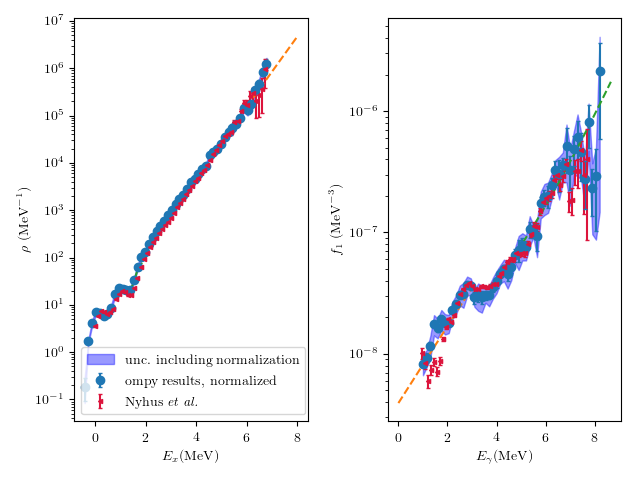

[]

In [22]:
gsf_ext_low = normGSF_mean.gsf_ext_low
gsf_ext_high = normGSF_mean.gsf_ext_high

gsf_fit = normGSF_mean.gsf

yscale ="log"
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_fit[:,0],rho_fit[:,1],
             yerr=rho_fit[:,1]*std_rel_nld["fit"],
             fmt="o",
             label=r"ompy results, normalized")
ax1.fill_between(rho_fit[:,0], 
                 rho_fit[:,1] - rho_fit[:,2], 
                 rho_fit[:,1] + rho_fit[:,2],
                 color='blue', alpha=0.4,
                 label="unc. including normalization")
ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
ax1.plot(discretes[:,0],discretes[:,1],"-")
ax1.set_yscale(yscale)

ax2.errorbar(gsf_fit[:,0],gsf_fit[:,1],
             yerr=gsf_fit[:,1]*std_rel_gsf["fit"],
             fmt="o")
ax2.fill_between(gsf_fit[:,0], 
                 gsf_fit[:,1] - gsf_fit[:,2], 
                 gsf_fit[:,1] + gsf_fit[:,2],
                 color='blue', alpha=0.4)
ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")
ax2.set_yscale(yscale)
#for i in range(N_samples_max):
#    ax2.plot(gsf_samples[i,:,0],gsf_samples[i,:,1],"o-", alpha=0.1)


ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

# Load and add published, normalized data:
rho_published = np.loadtxt("Dy164/data/rho164dy.txt", skiprows=2)
ax1.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=3, color="crimson",
                      label=r"Nyhus $\textit{et\,\,al.}$")
ax1.legend()

gsf_published = np.loadtxt("Dy164/data/rsf164dy.txt", skiprows=2)
ax2.errorbar(gsf_published[:, 1], gsf_published[:, 2], yerr=gsf_published[:, 3],
                      fmt="<", markersize=3, color="crimson",
                      label=r"Nyhus $\textit{et\,\,al.}$")


plt.tight_layout()
plt.plot()